## Load required libraries

In [9]:
import json
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import open3d as o3d

## Provide necessary file paths

In [10]:
## Provide PCD Input File
#ply_file_path = "/home/ali/nerfstudio/Processed_data/Bricon_Bridge/Transforms_backup/sparse_pc_reg.ply"  # note that the points clouds are post-processed
#ply_file_path = "/home/ali/nerfstudio/Processed_data/Bricon_Bridge/Outputs/pcd_extraction/pcd_Test3/pcd_alphaimages_unreg_mod2/Density_10M/filtered_transform_pcd_update2.ply"  # note that the points clouds are post-processed (unregistered)
ply_file_path = "/home/d8/3D-2D-Projection/transform_filtered_point_cloud_2.ply"  # note that the points clouds are post-processed (georegistered)

## Provide Transform Json Input File
#json_file_path = "/home/ali/nerfstudio/Processed_data/Bricon_Bridge/Transforms_backup/transforms_unreg.json" #unregistered
json_file_path = "/home/d8/3D-2D-Projection/sorted_transforms_reg.json" #georegistered

## Provide the Images paths
images_file_path = "/home/d8/3D-2D-Projection/SteelGirderImages/"
binary_mask_path = "/home/d8/3D-2D-Projection/BriconBridge_BinaryMask/"
rgb_mask_path = "/home/d8/3D-2D-Projection/SegmentationClass/"

## Define necessary functions

In [11]:
def extract_camera_parameters(json_file_path):
    # Open the JSON file and load the data
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Image dimensions
    image_width = data["w"]
    image_height = data["h"]
    
    # Camera intrinsic matrix
    intrinsic_matrix = np.array([
        [data["fl_x"], 0, data["cx"]],
        [0, data["fl_y"], data["cy"]],
        [0, 0, 1]
    ])
    
    # Camera distortion coefficients
    distortion_coeffs = np.array([
        data["k1"],
        data["k2"],
        data["p1"],
        data["p2"]
    ])
    
    # File names and transform matrices
    file_names = [frame["file_path"] for frame in data["frames"]]
    transform_matrix = [frame["transform_matrix"] for frame in data["frames"]]
    transform_matrix = np.array(transform_matrix)
    
    # Applied transformation (extend to 4x4 if necessary)
    applied_transform = np.array(data["applied_transform"])
    applied_transform = np.vstack([applied_transform, [0, 0, 0, 1]])  # Convert 3x4 to 4x4
    
    return {
        "image_width": image_width,
        "image_height": image_height,
        "intrinsic_matrix": intrinsic_matrix,
        "distortion_coeffs": distortion_coeffs,
        "file_names": file_names,
        "transform_matrix": transform_matrix,
        "applied_transform": applied_transform
    }
def project_3D_2D_mod(intrinsic_matrix, transform_matrix, point_homogen):
    """
    Project 3D points from world coordinates to image coordinates using intrinsic and extrinsic parameters.
    
    :param intrinsic_matrix: (3, 3) intrinsic matrix of the camera
    :param transform_matrix: (4, 4) transformation matrix from world to camera coordinates
    :param point_homogen: (N, 4) homogeneous 3D points in world coordinates
    :return: 
        - img_coordinate[:, :2]: (N, 2) pixel coordinates in the image
        - img_coordinate[:, 2]: (N,) depth values (scale factor) in camera space
        - cam_coordinate.T: (N, 3) camera coordinates of the points
    """
    
    # Step 1: Convert from world coordinate system to camera coordinate system
    cam_transform = np.linalg.inv(transform_matrix)  # (4, 4)
    cam_coordinate_homo = cam_transform @ point_homogen.T  # (4, N) homogeneous camera coordinates

    # Debug: Check camera coordinates
    print("Camera Homogeneous Coordinates:\n", cam_coordinate_homo)

    # Step 2: Flip Y and Z axis to match the camera coordinate system (if needed)
    cam_coordinate_homo[1, :] *= -1
    cam_coordinate_homo[2, :] *= -1

    # Step 3: Extract camera coordinates (ignore the homogeneous dimension)
    cam_coordinate = cam_coordinate_homo[:3, :]  # (3, N)

    # Step 4: Project camera coordinates onto the image plane using intrinsic matrix
    image_coord = intrinsic_matrix @ cam_coordinate  # (3, N)

    # Debug: Check projected coordinates
    print("Projected Image Coordinates (before division):\n", image_coord)

    # Step 5: Convert homogeneous coordinates to Euclidean coordinates (perspective division)
    scale_factors = np.clip(image_coord[2, :], 1e-8, np.inf)  # (N,) scale factors (Z values)

    # Perform perspective division (convert to 2D pixel coordinates)
    img_coordinate = image_coord.T  # (N, 3)
    img_coordinate[:, 0] /= scale_factors  # Divide x by Z
    img_coordinate[:, 1] /= scale_factors  # Divide y by Z

    # Debug: Check final 2D coordinates
    print("Final Image Coordinates:\n", img_coordinate[:, :2])

    # Step 6: Return image coordinates, depth (Z values), and camera coordinates
    return img_coordinate[:, :2], scale_factors, cam_coordinate.T


## Load the 3D pcd and extract the camera extrincic and intrinic matrix for projection

In [12]:
# Point cloud data
point_cloud_ply = o3d.io.read_point_cloud(ply_file_path)
point_cloud_np = np.asarray(point_cloud_ply.points)
point_cloud_rgb = np.asarray(point_cloud_ply.colors)
ones_column = np.ones((point_cloud_np.shape[0], 1))
point_homogen = np.hstack((point_cloud_np, ones_column))
print(point_homogen.shape)

# Camera parameters matrix
camera_params = extract_camera_parameters(json_file_path)
file_names = camera_params["file_names"]
intrinsic_matrix = camera_params["intrinsic_matrix"]
distortion_coeffs = camera_params["distortion_coeffs"]
transform_matrix = camera_params["transform_matrix"]

(9923241, 4)


## 3D-2D Projection for single view image

In [13]:
# # Define RGB mask pixel values and colors for each label
# mask_labels = {
#     (0, 0, 0): 'Background',
#     (123, 40, 62): 'Girder',
#     (211, 117, 213): 'Pier',
#     (247, 234, 226): 'Bearing'
# }

# mask_colors = {
#     'Background': (0, 0, 0),                     # Black
#     'Girder': (123 / 255, 40 / 255, 62 / 255),   # Normalized RGB for Girder
#     'Pier': (211 / 255, 117 / 255, 213 / 255),   # Normalized RGB for Pier
#     'Bearing': (247 / 255, 234 / 255, 226 / 255) # Normalized RGB for Bearing
# }

# # Load and process a single RGB and mask image
# file_names_mod = [name.replace('images/', '') for name in file_names]
# image_idx = 2
# img = cv2.imread(images_file_path + file_names_mod[image_idx])
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# image_height, image_width, _ = img.shape

# # Load the RGB mask image
# rgb_mask_file = rgb_mask_path + file_names_mod[image_idx].replace('.JPG', '.png')
# rgb_mask_image = cv2.imread(rgb_mask_file)
# rgb_mask_image = cv2.cvtColor(rgb_mask_image, cv2.COLOR_BGR2RGB)

# # Create binary masks for Girder, Pier, and Bearing
# girder_mask = cv2.inRange(rgb_mask_image, (123, 40, 62), (123, 40, 62))
# pier_mask = cv2.inRange(rgb_mask_image, (211, 117, 213), (211, 117, 213))
# bearing_mask = cv2.inRange(rgb_mask_image, (247, 234, 226), (247, 234, 226))

# # Step 1: Project 3D points(World-->Camera) onto the 2D image plane and extract the image coordinates (2D), depth (scale) and camera coordinates (3D) -----------------------------------
# img_coordinate, scales, cam_coords = project_3D_2D_mod(
#     intrinsic_matrix, np.array(transform_matrix[image_idx]), point_homogen
# )

# # Filter valid points within image bounds
# valid_points_mask = (
#     (img_coordinate[:, 0] >= 0) & (img_coordinate[:, 0] < image_width) &
#     (img_coordinate[:, 1] >= 0) & (img_coordinate[:, 1] < image_height) &
#     (scales > 0)
# )
# img_coordinate = img_coordinate[valid_points_mask]
# filtered_depths = scales[valid_points_mask]
# cam_valid = cam_coords[valid_points_mask]
# point_cloud_rgb = np.asarray(point_cloud_ply.colors)[valid_points_mask]  # Valid RGB points

# # Step 2: Convert projected 2D coordinates to integers for matching -----------------------------------------------------------------
# img_coordinate_int = np.round(img_coordinate).astype(int) ## finding the nearest pixel for projected 2D image coordinate

# # Step 3: Extract girder, pier, bearing and background 2D images coordinates corresponding to rgb mask pixels
# girder_points = []
# pier_points = []
# bearing_points = []
# background_points = []

# # Extract points based on mask labels
# for idx, coord in enumerate(img_coordinate_int):
#     x, y = coord[0], coord[1]

#     # Ensure the pixel coordinates (x, y) are within the image bounds (Step 6 check)
#     if 0 <= y < image_height and 0 <= x < image_width:
#         rgb_value = tuple(rgb_mask_image[y, x])
#         label = mask_labels.get(rgb_value, 'Unknown')

#         # Group points by label
#         if label == 'Girder':
#             girder_points.append((idx, img_coordinate_int[idx]))  # Store index and 2D coordinate
#         elif label == 'Pier':
#             pier_points.append((idx, img_coordinate_int[idx]))
#         elif label == 'Bearing':
#             bearing_points.append((idx, img_coordinate_int[idx]))
#         elif label == 'Background':
#             background_points.append((idx, img_coordinate_int[idx]))

# # Convert lists to numpy arrays for plotting (only coordinates)
# girder_coords = np.array([p[1] for p in girder_points])
# pier_coords = np.array([p[1] for p in pier_points])
# bearing_coords = np.array([p[1] for p in bearing_points])
# background_coords = np.array([p[1] for p in background_points])

# # Display extracted points and their indices for verification
# print(f'Girder Points: {len(girder_points)}, Indices: {[p[0] for p in girder_points[:10]]}...')
# print(f'Pier Points: {len(pier_points)}, Indices: {[p[0] for p in pier_points[:10]]}...')
# print(f'Bearing Points: {len(bearing_points)}, Indices: {[p[0] for p in bearing_points[:10]]}...')
# print(f'Background Points: {len(background_points)}, Indices: {[p[0] for p in background_points[:10]]}...')

# # Perform Visualization:
# fig, axs = plt.subplots(1, 3, figsize=(20, 6))
# # Original Image
# axs[0].imshow(img)
# axs[0].set_title("Original Image")
# axs[0].axis('off')

# # 2D Image Mask
# axs[1].imshow(rgb_mask_image)
# axs[1].set_title("2D Image Mask")
# axs[1].axis('off')

# # 3D Points Projection on 2D Image with Labels
# axs[2].imshow(img)
# axs[2].scatter([p[1][0] for p in girder_points], [p[1][1] for p in girder_points], s=1, color=mask_colors['Girder'], label='Girder')
# axs[2].scatter([p[1][0] for p in pier_points], [p[1][1] for p in pier_points], s=1, color=mask_colors['Pier'], label='Pier')
# axs[2].scatter([p[1][0] for p in bearing_points], [p[1][1] for p in bearing_points], s=1, color=mask_colors['Bearing'], label='Bearing')
# #axs[2].scatter([p[1][0] for p in background_points], [p[1][1] for p in background_points], s=1, color=mask_colors['Background'], label='Background')
# axs[2].set_title("3D PCD Projection on 2D Image")
# axs[2].legend(loc='upper left')
# axs[2].axis('off')

## Visualizaton for each 3D point projected to 2D according to mask label

In [14]:
# # Function to create Open3D point cloud with RGB colors
# def create_point_cloud_with_rgb(points, colors):
#     pcd = o3d.geometry.PointCloud()
#     pcd.points = o3d.utility.Vector3dVector(points)
#     pcd.colors = o3d.utility.Vector3dVector(colors)
#     return pcd
    
# # Step 4: Extract 3D points in camera coordinate corresponding to extracted girder, pier, bearing and background 2D image coordinates -------------------------------------------------

# girder_3d = np.array([cam_valid[p[0]] for p in girder_points])
# pier_3d = np.array([cam_valid[p[0]] for p in pier_points])
# bearing_3d = np.array([cam_valid[p[0]] for p in bearing_points])
# background_3d = np.array([cam_valid[p[0]] for p in background_points])

# # Correctly extract corresponding RGB values for each point cloud
# girder_rgb = point_cloud_rgb[[p[0] for p in girder_points]]
# pier_rgb = point_cloud_rgb[[p[0] for p in pier_points]]
# bearing_rgb = point_cloud_rgb[[p[0] for p in bearing_points]]
# background_rgb = point_cloud_rgb[[p[0] for p in background_points]]

# # Create Open3D point clouds for visualization
# girder_pcd = create_point_cloud_with_rgb(girder_3d, girder_rgb)
# pier_pcd = create_point_cloud_with_rgb(pier_3d, pier_rgb)
# bearing_pcd = create_point_cloud_with_rgb(bearing_3d, bearing_rgb)
# background_pcd = create_point_cloud_with_rgb(background_3d, background_rgb)

# # Visualization: It will how the 3D points in camera coordinate system are projected to each category in 2D image coordinate 
# o3d.visualization.draw_geometries([girder_pcd],
#                                   width=1200, height=800)

In [18]:
def create_point_cloud_with_rgb(points, colors):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd

# Define label mappings
mask_labels = {
    (0, 0, 0): 'Background',
    (123, 40, 62): 'Girder',
    (211, 117, 213): 'Pier',
    (247, 234, 226): 'Bearing'
}

# Define normalized color values for masks
mask_colors = {
    'Background': (0, 0, 0),                     
    'Girder': (123 / 255, 40 / 255, 62 / 255),   
    'Pier': (211 / 255, 117 / 255, 213 / 255),   
    'Bearing': (247 / 255, 234 / 255, 226 / 255) 
}

# Process each file name to remove path prefix
file_names_mod = [name.replace('images/', '') for name in file_names]

# Initialize frequency arrays for each category
freq_point_girder = np.zeros(len(point_homogen))
freq_point_pier = np.zeros(len(point_homogen))
freq_point_bearing = np.zeros(len(point_homogen))
freq_point_background = np.zeros(len(point_homogen))

# Loop through each image
for i in range(101):  
    image_idx = i
    # Load RGB image and mask
    img = cv2.imread(images_file_path + file_names_mod[image_idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_height, image_width, _ = img.shape

    rgb_mask_file = rgb_mask_path + file_names_mod[image_idx].replace('.JPG', '.png')
    rgb_mask_image = cv2.imread(rgb_mask_file)
    rgb_mask_image = cv2.cvtColor(rgb_mask_image, cv2.COLOR_BGR2RGB)

    # Create binary masks for each category
    girder_mask = cv2.inRange(rgb_mask_image, (123, 40, 62), (123, 40, 62))
    pier_mask = cv2.inRange(rgb_mask_image, (211, 117, 213), (211, 117, 213))
    bearing_mask = cv2.inRange(rgb_mask_image, (247, 234, 226), (247, 234, 226))

    # Project 3D points onto 2D image plane
    img_coordinate, scales, cam_coords = project_3D_2D_mod(
        intrinsic_matrix, np.array(transform_matrix[image_idx]), point_homogen
    )

    # Filter valid points within image bounds
    valid_points_mask = (
        (img_coordinate[:, 0] >= 0) & (img_coordinate[:, 0] < image_width) &
        (img_coordinate[:, 1] >= 0) & (img_coordinate[:, 1] < image_height) &
        (scales > 0)
    )
    img_coordinate = img_coordinate[valid_points_mask]
    cam_valid = cam_coords[valid_points_mask]
    point_cloud_rgb = np.asarray(point_cloud_ply.colors)[valid_points_mask]

    # Convert projected coordinates to integer pixel positions
    img_coordinate_int = np.round(img_coordinate).astype(int)

    # Classify points by label based on RGB mask
    for idx, coord in enumerate(img_coordinate_int):
        x, y = coord[0], coord[1]

        # Ensure the pixel coordinates (x, y) are within the image bounds
        if 0 <= y < image_height and 0 <= x < image_width:
            rgb_value = tuple(rgb_mask_image[y, x])
            label = mask_labels.get(rgb_value, 'Unknown')

            # Update frequency based on label
            if label == 'Bearing':
                freq_point_bearing[idx] += 1
            elif label == 'Pier':
                freq_point_pier[idx] += 1
            elif label == 'Girder':
                freq_point_girder[idx] += 1
            elif label == 'Background':
                freq_point_background[idx] += 1

    print(f"Processed image {i}")

Camera Homogeneous Coordinates:
 [[  0.58912776   0.76004422  -0.75103055 ...  -8.3979205    5.93375184
   -9.03116298]
 [  1.03824663   0.58072577   0.10061734 ...   3.75108298  -4.07195969
    2.90480904]
 [-13.57616981 -13.67538856 -12.16603215 ... -20.6609675  -10.33885958
  -21.74501449]
 [  1.           1.           1.         ...   1.           1.
    1.        ]]
Projected Image Coordinates (before division):
 [[3.93219613e+04 4.02251730e+04 3.05102708e+04 ... 2.54876329e+04
  5.02197222e+04 2.61129659e+04]
 [2.09203624e+04 2.27946311e+04 2.18184559e+04 ... 2.38027722e+04
  3.39284834e+04 2.89121505e+04]
 [1.35761698e+01 1.36753886e+01 1.21660321e+01 ... 2.06609675e+01
  1.03388596e+01 2.17450145e+01]]
Final Image Coordinates:
 [[2896.39580782 1540.96204234]
 [2941.42815781 1666.83608627]
 [2507.82427917 1793.39127301]
 ...
 [1233.61274629 1152.06474217]
 [4857.37540233 3281.64660498]
 [1200.87139377 1329.59904705]]
Processed image 0
Camera Homogeneous Coordinates:
 [[  0.03867

In [32]:
# Previous method
valid_freq_point1 = freq_point_girder > 95
girder_valid = cam_coords[valid_freq_point1]
girder_valid_rgb = np.asarray(point_cloud_ply.colors)[valid_freq_point1]
girder_valid_pcd = create_point_cloud_with_rgb(girder_valid, girder_valid_rgb)

o3d.visualization.draw_geometries([girder_valid_pcd],
                                  width=1200, height=800)

[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


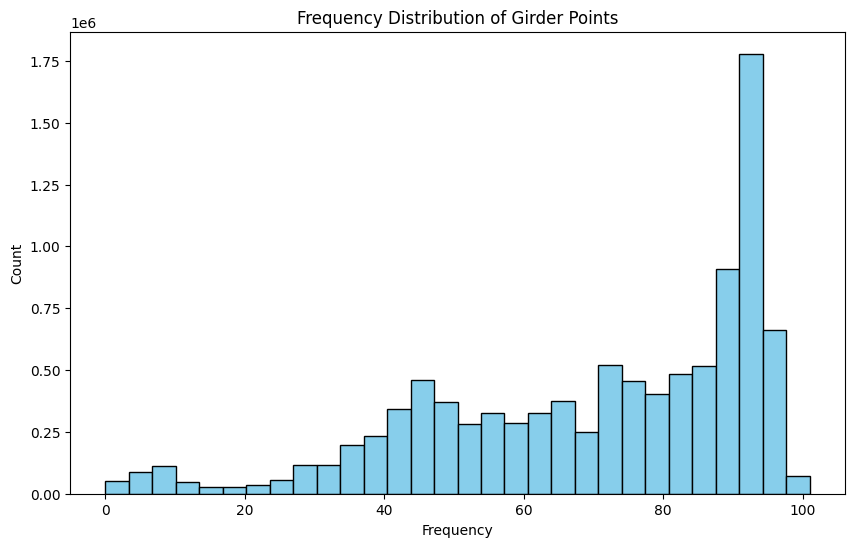

Girder - Mean Frequency: 70.32188354591005, Standard Deviation: 23.10450907219722
Girder - 90th Percentile Threshold: 95.0


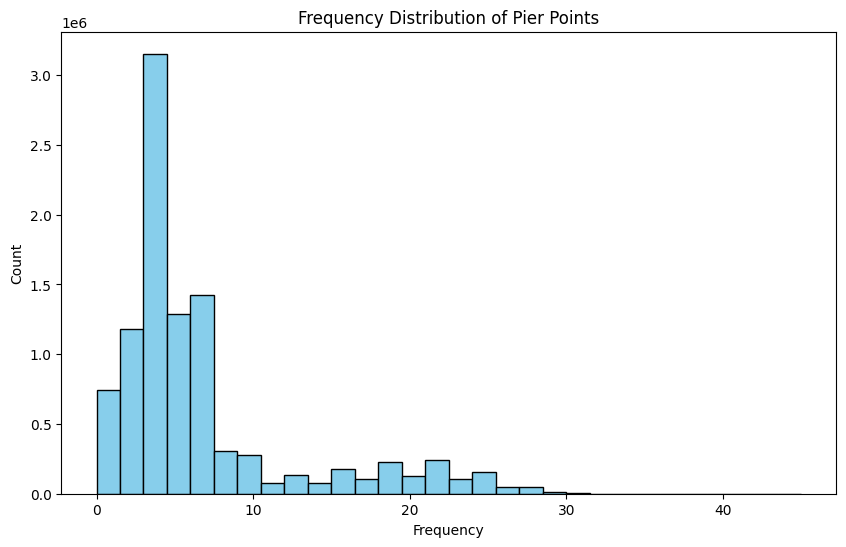

Pier - Mean Frequency: 6.445483385921999, Standard Deviation: 5.996096760683783
Pier - 90th Percentile Threshold: 21.0


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
from sklearn.cluster import DBSCAN

# Helper function to create and visualize point cloud
def create_point_cloud_with_rgb(points, colors):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd

# Helper function to process each component with DBSCAN
def process_component_with_dbscan(freq_point_component, cam_coords, point_cloud_colors, component_name):
    # Plot histogram for frequency distribution to visualize the spread
    plt.figure(figsize=(10, 6))
    plt.hist(freq_point_component, bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Frequency Distribution of {component_name} Points")
    plt.xlabel("Frequency")
    plt.ylabel("Count")
    plt.show()

    # Calculate mean and standard deviation for better understanding
    mean_freq = np.mean(freq_point_component)
    std_dev_freq = np.std(freq_point_component)
    print(f"{component_name} - Mean Frequency: {mean_freq}, Standard Deviation: {std_dev_freq}")

    # Dynamic threshold using 90th percentile
    threshold_percentile = np.percentile(freq_point_component, 94)
    print(f"{component_name} - 90th Percentile Threshold: {threshold_percentile}")

    # Select points above the threshold
    valid_freq_point = freq_point_component > threshold_percentile
    valid_points = cam_coords[valid_freq_point]
    valid_rgb = point_cloud_colors[valid_freq_point]

    # Apply DBSCAN for further filtering
    if len(valid_points) > 0:  # Ensure there are points to cluster
        dbscan = DBSCAN(eps=0.1, min_samples=10)  # Adjust eps and min_samples as needed
        labels = dbscan.fit_predict(valid_points)

        # Filter points that are not labeled as noise (-1)
        core_points_mask = labels != -1
        clustered_points = valid_points[core_points_mask]
        clustered_rgb = valid_rgb[core_points_mask]

        # Create and visualize the point cloud
        clustered_pcd = create_point_cloud_with_rgb(clustered_points, clustered_rgb)
        o3d.visualization.draw_geometries([clustered_pcd], width=1200, height=800)
    else:
        print(f"No points to process for {component_name} after frequency and DBSCAN filtering.")

# Process each component individually
process_component_with_dbscan(freq_point_girder, cam_coords, np.asarray(point_cloud_ply.colors), "Girder")
process_component_with_dbscan(freq_point_pier, cam_coords, np.asarray(point_cloud_ply.colors), "Pier")
# process_component_with_dbscan(freq_point_bearing, cam_coords, np.asarray(point_cloud_ply.colors), "Bearing")



In [26]:
import numpy as np

# Calculate mean and standard deviation of frequency counts
mean_freq = np.mean(freq_point)
std_freq = np.std(freq_point)

# Set z-score threshold (you can adjust this value)
z_threshold = 1.96  # roughly the top 5% in a normal distribution

# Calculate z-scores for each point
z_scores = (freq_point - mean_freq) / std_freq

# Identify valid points based on z-score threshold
valid_freq_point1 = z_scores > z_threshold

# Extract valid points and colors
girder_valid = cam_coords[valid_freq_point1]
girder_valid_rgb = np.asarray(point_cloud_ply.colors)[valid_freq_point1]
girder_valid_pcd = create_point_cloud_with_rgb(girder_valid, girder_valid_rgb)

# Visualize
o3d.visualization.draw_geometries([girder_valid_pcd], width=1200, height=800)


[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.
